In [9]:
%matplotlib inline
from __future__ import division, print_function
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
import h5py
import glob
import pmefm
from munch import Munch
import lockin
from kpfm.util import align_labels
from collections import OrderedDict

In [10]:
files = glob.glob("*.h5")
fhs = {key: h5py.File(key, 'r') for key in files}

In [11]:
d_time = OrderedDict([
  (1,'../data/KPFM-linescans/170216-1755DPh-BTBT-15V-2s.h5'),
#   (2,'../data/KPFM-linescans/170216-1751DPh-BTBT-15V-2s.h5'),
  (4, '../data/KPFM-linescans/170216-1749DPh-BTBT-15V-8s.h5'),
  (8,'../data/KPFM-linescans/170216-1750DPh-BTBT-15V-8s.h5'),
  (16, '../data/KPFM-linescans/170216-1748DPh-BTBT-15V-16s.h5'),
    # Channel looks different at 128 s linescan
#   (128,'../data/KPFM-linescans/170216-1820DPh-BTBT-15V-128s.h5'),
])

dtime_fh = OrderedDict((key, h5py.File(val, 'r')) for key, val in d_time.items())

In [12]:
for key, fh in dtime_fh.items():
    print("{:3d} : {}".format(key, fh.attrs['Inputs.Scan Size']/fh.attrs['Inputs.Scan rate [Hz]']))

  1 : 1.0
  4 : 4.0
  8 : 8.0
 16 : 16.0


In [13]:
fh.attrs.items()

[(u'Inputs.AC tip rms (V)', 1.5),
 (u'Inputs.CPD', '    Dev1/ai6'),
 (u'Inputs.Czz', '    Dev1/ai5'),
 (u'Inputs.D (s)', 5.0000000000000002e-05),
 (u'Inputs.Drain voltage', -1.0),
 (u'Inputs.End scan [V]', 25.0),
 (u'Inputs.Gain (x or y)', 27.0),
 (u'Inputs.Gate voltage', -10.0),
 (u'Inputs.I (1/s)', 50.0),
 (u'Inputs.LockinE', '    Dev1/ai20'),
 (u'Inputs.Output Buffer', 65536),
 (u'Inputs.P', 1.2),
 (u'Inputs.Pos Mod Freq (Hz)', 4.5),
 (u'Inputs.Pos Mod Slope dB', 6.0),
 (u'Inputs.Pos Mod TC ms)', 10.0),
 (u'Inputs.Pos Mod rms (V)', 0.0),
 (u'Inputs.SRS TC (ms)', 10.0),
 (u'Inputs.SRS mod freq (Hz)', 160.0),
 (u'Inputs.SRS slope dB', 6.0),
 (u'Inputs.Scan Direction', 1),
 (u'Inputs.Scan Size', 262144),
 (u'Inputs.Scan rate [Hz]', 16384.0),
 (u'Inputs.Start scan [V]', -70.0),
 (u'Inputs.X Channel', '    Dev1/ao0'),
 (u'Inputs.Y Channel', '    Dev1/ao1'),
 (u'Inputs.Z above gold (nm)', 150.0),
 (u'Inputs.timeout', 150.0),
 (u'Inputs.xy nm/V', 30.0),
 (u'Inputs.z nm/V', 25.0),
 (u'Curre

In [14]:
x_volts = np.linspace(-70, 25, fh['Czz'][:].size)

In [15]:
fs = dtime_fh[16].attrs['Inputs.Scan rate [Hz]']
Nignore = int(fir.size//2)
Ndec = int(np.floor(fs/400.0))
CPD16 = data[16]['CPD'][Nignore:-Nignore:Ndec]

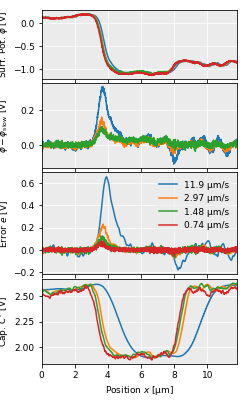

In [16]:
plt.rc('font', size=9)
fig, axes = plt.subplots(nrows=4, figsize=(3.5, 6.5), 
                         subplot_kw=dict(facecolor='0.92'), 
                         gridspec_kw=dict(height_ratios=(0.8, 1, 1.2, 1)),
                         sharex=True)
fig.subplots_adjust(hspace=0.05)

axes_ = [axes[0], axes[2], axes[3]]
dsnames = ['CPD', 'LockinE', 'Czz']
scales = [1, 1, 1]

labels = [u"11.9 µm/s", u"2.97 µm/s", u"1.48 µm/s", u"0.74 µm/s"]

x_um = (x_volts - x_volts[0]) * 0.125

data = OrderedDict([(key, Munch()) for key in dtime_fh])

for label, (key, fh) in zip(labels,  dtime_fh.items()):
    fs = fh.attrs['Inputs.Scan rate [Hz]']
    fir = lockin.lock2(1, 100, 400, fs, print_response=False)
    Nignore = int(fir.size//2)
    Ndec = int(np.floor(fs/400.0))
    for ax, dsname, scale in zip(axes_, dsnames, scales):
        data[key][dsname] = ds = signal.fftconvolve(fh[dsname][:], fir,  mode='same')
        ax.plot(x_um[Nignore:-Nignore:Ndec], ds[Nignore:-Nignore:Ndec]*scale, label=label)
    

for ax in axes:
    ax.grid(color='1',zorder=0)

axes[2].legend(facecolor='0.92', edgecolor='none', framealpha=0.6)
axes[0].set_ylabel("Surf. Pot. $\phi$ [V]")
axes[1].set_ylabel("$\\phi - \\phi_{\\mathrm{slow}}$ [V]")

for key, val in data.items():
    if key != 16:
        fs = fh.attrs['Inputs.Scan rate [Hz]']
        Nignore = int(fir.size//2)
        Ndec = int(np.floor(fs/400.0))
        axes[1].plot(x_um[Nignore:-Nignore:Ndec], val['CPD'][Nignore:-Nignore:Ndec] - CPD16)

axes[2].set_ylabel("Error $e$ [V]")
axes[3].set_ylabel(u"Cap. $C''$ [V]")
axes[-1].set_xlim(0, 11.8)
axes[-1].set_xlabel(u"Position $x$ [µm]")

align_labels(axes, 10)

ValueError: x and y must have same first dimension, but have shapes (198676,) and (197877,)

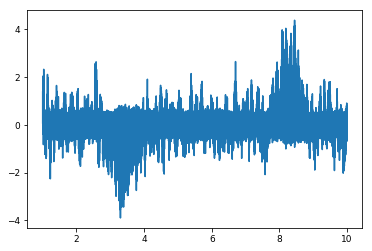

In [43]:
m = (x_um > 1) & (x_um < 10)

dCzdx = np.gradient(data[16].Czz[m])/np.gradient(x_um[m])
filt = np.ones(800)
filt = filt/np.sum(filt)
Czz_filt = signal.fftconvolve(data[16].Czz[m], filt,  mode='valid')
dCz_filt = signal.fftconvolve(dCzdx, filt,  mode='valid')
plt.plot(x_um[m], dCzdx)
plt.plot(x_um[m], dCz_filt)

In [47]:
0.6 * 0.03

0.018

In [48]:
0.6 * 0.03 /20

0.0009

In [158]:
fig.savefig("../figs/SI-scan-speed.pdf", bbox_inches='tight', pad_inches=0.2)

In [124]:
!open ../figs/SI-scan-speed.pdf